# 0.0. IMPORTS

In [1]:
import pickle
import psycopg2
import warnings

import numpy                 as np
import pandas                as pd
import seaborn               as sns
import scipy.stats           as ss
import matplotlib.pyplot     as plt
import imblearn.combine      as c

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from IPython.display         import Image

from boruta import BorutaPy

%matplotlib inline
warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
def get_tables(table):
    '''This functions receives a list with table names to be loaded from the database'''
    # to create a df to store all loaded dfs
    df_tab = pd.DataFrame()
    
    # iterate over the list of tables, load each one, take the column names and create a final df
    for tab in table:
        sql = 'SELECT * FROM pa004.{}'.format(tab)
        cur.execute(sql)
        cols = [desc[0] for desc in cur.description] # saving the column names
        data = []
        for i in cur:
            data.append(i)
        df = pd.DataFrame(data, columns = cols)
        
        if 'id' in df_tab:
            df_tab = df_tab.merge(df, how = 'left', left_on = 'id', right_on = 'id')
        else:
            df_tab = df.copy()
    return df_tab

def num_descriptive(num_attributes):
    # Central Tendendy: mean, median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # Dispersion: std, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
    d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

    # concatenating them and printing
    m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
    return m

def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

    cm = pd.crosstab(x, y).matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

## 0.2. Collecting the Data

In [35]:
# creating parameters  to access the database
params = dict(
    database='',
    user='',
    password='',
    host='',
    port=
)
# creating the connection
conn = psycopg2.connect(**params)

# creating the cursor
cur = conn.cursor()

**Let's find out how many tables there are**

In [36]:
sql = "select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)'"
cur.execute(sql)
tables = cur.fetchall()
table_names = []
for table, database in enumerate(tables, start=1):
    table_names.append(database[0])
    print(f'Table {table}: {database[0]}')

Table 1: users
Table 2: vehicle
Table 3: insurance


**Now, let's load them all and store them in a single dataframe.**

In [32]:
#df_raw =  get_tables(table_names) # fucntion defined in section 0.1: Helper Functions
#cur.close()
#conn.close()

#pickle.dump( df_raw, open( '../data/df_raw.pkl', 'wb') ) # saving the df as pickle format
#df_raw = pickle.load(open('../data/df_raw.pkl', 'rb'))

Splitting the data with stratified sampling in order to keep response proportion in both train and test datasets

In [158]:
splitting = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in splitting.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)

pickle.dump( train_dataset, open( '../data/train_dataset.pkl', 'wb') )
pickle.dump( test_dataset, open( '../data/test_dataset.pkl', 'wb') )

In [102]:
df_raw = pickle.load(open('../data/train_dataset.pkl', 'rb'))

In [3]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,153813,Female,23,34.0,152.0,1,< 1 Year,Yes,0,32451.0,278,1
1,43216,Male,24,36.0,152.0,1,< 1 Year,Yes,0,37183.0,137,0
2,335441,Female,21,50.0,160.0,1,< 1 Year,No,1,56038.0,279,0
3,76325,Female,23,3.0,124.0,1,< 1 Year,Yes,0,38646.0,67,0
4,323690,Female,41,28.0,124.0,1,1-2 Year,Yes,0,37008.0,172,1


# 1.0. STEP 1: DATA DESCRIPTION

In [103]:
df1 = df_raw.copy()

# deletting df_raw
#del df_raw

## 1.1. Data Dimensions

In [49]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 342998
Number of Columns: 12


## 1.2. Data Types

In [164]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342998 entries, 0 to 342997
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    342998 non-null  int64  
 1   gender                342998 non-null  object 
 2   age                   342998 non-null  int64  
 3   region_code           342998 non-null  float64
 4   policy_sales_channel  342998 non-null  float64
 5   driving_license       342998 non-null  int64  
 6   vehicle_age           342998 non-null  object 
 7   vehicle_damage        342998 non-null  object 
 8   previously_insured    342998 non-null  int64  
 9   annual_premium        342998 non-null  float64
 10  vintage               342998 non-null  int64  
 11  response              342998 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 31.4+ MB


## 1.3. Checking for Missing Values

In [165]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Checking the Target Balance


In [166]:
df1['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

So, the data is very imbalanced.

## 1.5. Descriptive Statistics

In [167]:
num_attributes = df1[['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']]
cat_attributes = df1.drop(['id','age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage'], axis = 1)

### 1.5.1 Numerical Attributes

In [168]:
num_descriptive(num_attributes) # fucntion defined in section 0.1: Helper Functions

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,age,20.0,85.0,65.0,25.0,36.0,49.0,38.827900,15.517065,0.671923,-0.567571
1,region_code,0.0,52.0,52.0,15.0,28.0,35.0,26.395349,13.230572,-0.115460,-0.866988
2,policy_sales_channel,1.0,163.0,162.0,29.0,135.0,152.0,112.037770,54.204455,-0.899940,-0.971009
3,annual_premium,2630.0,540165.0,537535.0,24405.0,31680.0,39411.0,30581.030884,17220.631696,1.713080,31.874216
4,vintage,10.0,299.0,289.0,82.0,154.0,227.0,154.346043,83.674152,0.002822,-1.200926


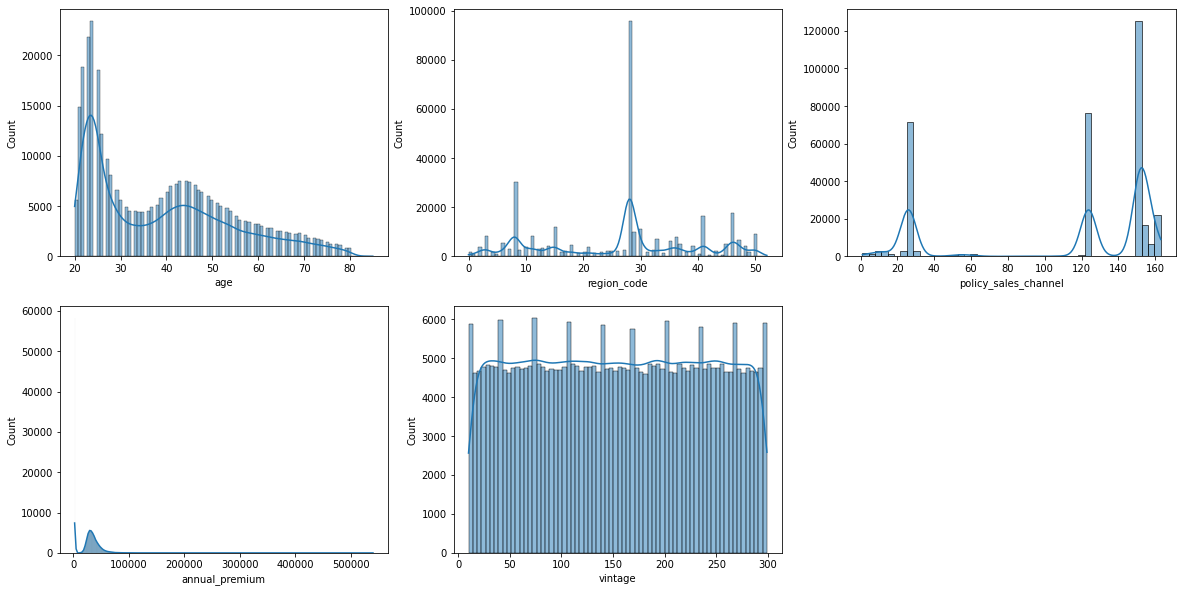

In [169]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(2, 3, 1);
sns.histplot(num_attributes['age'], kde=True)

plt.subplot(2, 3, 2);
sns.histplot(num_attributes['region_code'], kde=True)

plt.subplot(2, 3, 3);
sns.histplot(num_attributes['policy_sales_channel'], kde=True)

plt.subplot(2, 3, 4);
sns.histplot(num_attributes['annual_premium'], kde=True)

plt.subplot(2, 3, 5);
sns.histplot(num_attributes['vintage'], kde=True);

**Conclusions**:
- `age` seems not to have any inconsistent value (minimum of 20 and maximum of 85).
- `annual_premium` shows a large range, meaning that there're customers who paid too little and too much to the company
- Skewness:
    + all variables have a low skewness. 
    + `region_code` and `policy_sales_channel` have negative skewness, meaning that the observations are slightly concentrated on the the right side of the distribution;
    + `age` and `annual_premium` have a low positive skewness, meaning that the observations are slightly concentrated on the left side of the distribuition.
- Kurtosis:
    + except by `annual_premium`, all fariables have a low kurtosis coefficient, meaning that there are fewer values close to the mean (Platykurtic). `annual_premium`, otherwise, have a very leptokurtic distribution, meaning that there are more values close to the mean.

### 1.5.2. Categorical Attributes

In [149]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                2
driving_license       2
vehicle_age           3
vehicle_damage        2
previously_insured    2
response              2
dtype: int64

In [141]:
# changing some numeric variables to object so the functions can works well
cat_attributes['driving_license'] = cat_attributes['driving_license'].map({1: 'yes', 0:'no' })
cat_attributes['previously_insured'] = cat_attributes['previously_insured'].map({1: 'yes', 0:'no' })
cat_attributes['response'] = cat_attributes['response'].map({1: 'yes', 0:'no' })

cat_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

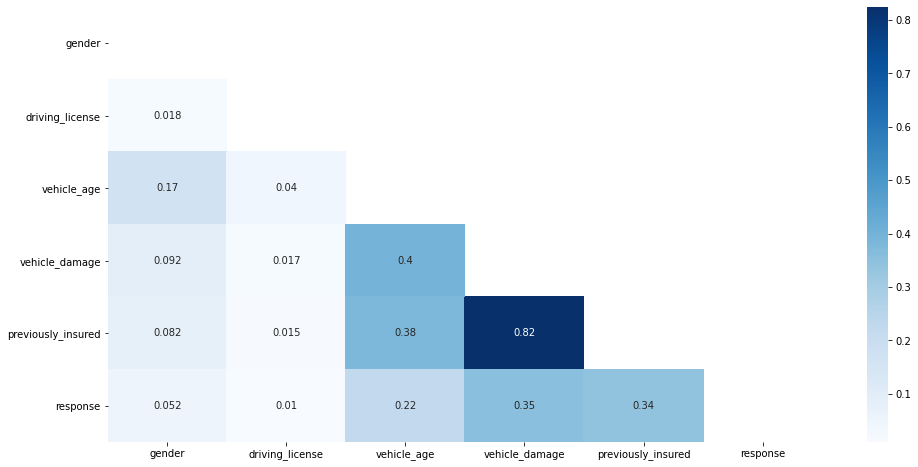

In [148]:
cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)
mask = np.zeros_like( cat_corr, dtype=np.bool )
mask[np.triu_indices_from( mask )] = True

plt.subplots( figsize = ( 16,8 ) )
sns.heatmap( cat_corr, cmap='Blues', mask = mask, annot=True)

# 2.0. STEP 2: FEATURE ENGINEERING AND HYPOTHESIS CREATION

In [5]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

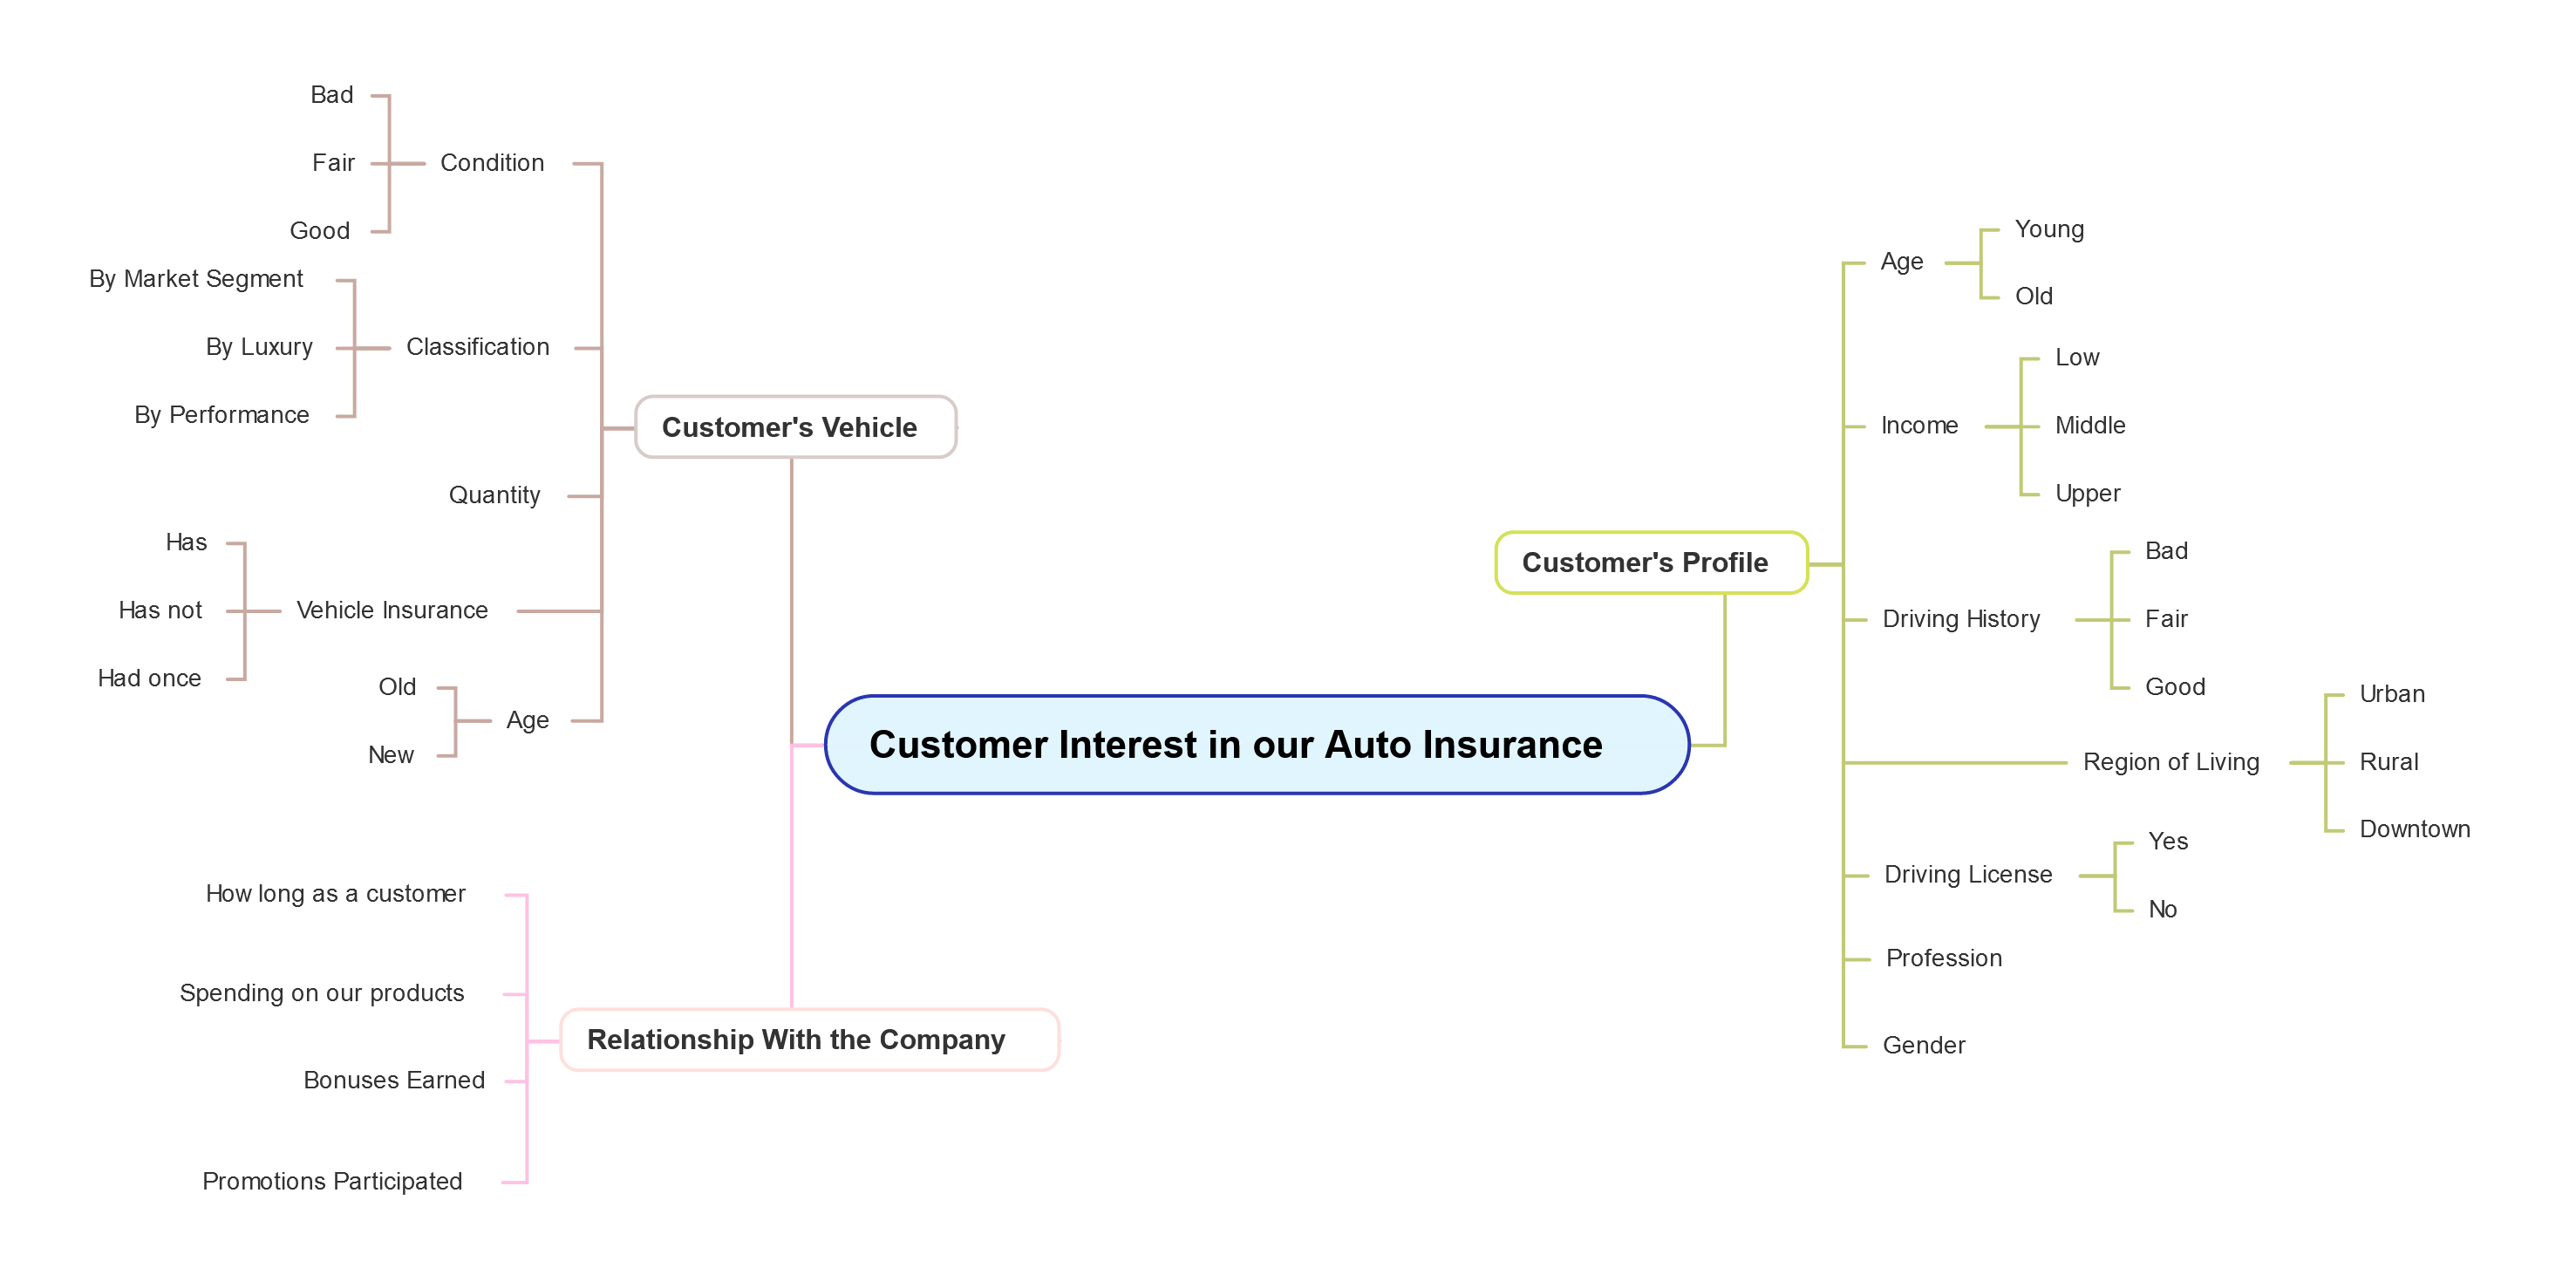

In [3]:
Image( '../imgs/mind_map.png' )

## 2.2. Hypothesis Creation

### 2.2.1. Customer's Profile Hypothesis

**1.** Middle aged customers should be more likely to purchase the vehicle insurance.

**2.** The higher the customer's income, the more likely he/she should be to purchase the insurance.

**3.** Customers who have a bad driving history should be more likely to purchase the vehicle insurance.

**4.** Customers from a dangerous region should be more likely to purchase the vehicle insurance.

**5.** Customers who have driving license should be more likely to purchase the vehicle insurance.

**6.** Customers who live far from home should be more likely to purchase the vehicle insurance.

**7.** Customers who use their own vehicle at work should be more likely to purchase the vehicle insurance.

**8.** Women are more likely to purchase a vehicle insurance than men.

### 2.2.2. Relationship with the Company

**1.** The longer as a customer, the more likely to purchase the vehicle insurance he/she should be.

**2.** Customers who have had purchased our health insurance should be more likely to purchase our vehicle one.

**3.** The more the customer spent on our products, the more he/she should be to purchase the vehicle insurance.

**4.** Customers who have ever earned some bonus should be more likely to purchase the vehicle insurance.

**5.** Customers who have ever participated in promotions should be more likely to purchase the vehicle insurance.

### 2.2.3. Vehicle

**1.** The younger the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.

**2.** The better the customer's vehicle condition, the more likely he/she should be to purchase the vehicle insurance.

**3.** The higher the quantity of vehicles a customer has, the more likely the/she should be to purchase the vehicel insurance.

**4.** The more expensive the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.

**5.** Customers who don't have a vehicle insurance should be more likely to purchase one.

## 2.3. Hypothesis Final List

Now, we'll filter some hypothesis based on availability of data. After look at the dataset we adapted some hypothesis to fit the data we have, since we need to look at the feature's relevance in EDA section.

**1.** Middle aged customers should be more likely to purchase the vehicle insurance.

**2.** Customers who have driving license should be more likely to purchase the vehicle insurance.

<s>**3.** Customers who have a bad driving history should be more likely to purchase the vehicle insurance.</s><br>
**3.** Customers who have their vehicles damagedin the past should be more likely to purchase the vehicle insurance.

**4.** Women are more likely to purchase a vehicle insurance than men.

<s>**5.** Customers from a dangerous region should be more likely to purchase the vehicle insurance.</s><br>
**5.** The customer's interest for vehicle insurance should differ between region codes.

**6.** The longer as a customer, the more likely to purchase the vehicle insurance he/she should be.

**7.** The more the customer spent on our products, the more he/she should be to purchase the vehicle insurance.

**8.** Customers who spent more in less time as a customer are more likely to purchase the vehicle insurance. 

**9.** The younger the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.

**10.** Customers who don't have a vehicle insurance should be more likely to purchase one.

## 2.4. Feature Engineering

To validate the H8, we need to create a new feature containing how much the customer spent with the health insurance in the agency over the period he/she is a customer (number of days the customer joined the company through the purchase of health insurance).

In [6]:
df2['premium_vintage'] = df2['annual_premium'] / df2['vintage']

Since vehicle insurance premium starts to increase around the age of 60 ([see here](https://www.valuepenguin.com/how-age-affects-auto-insurance-costs)), let's create a categorical variable containing whether the customer is older than 60 years or not. This new feature can get the interest of the 'after 60s' customers in purchasing the insurance.

In [7]:
df2['after_60'] = df2.apply( lambda x: 0 if x['age'] < 60 else 1, axis = 1)

In [8]:
df2['vintage_months'] = df2['vintage']/30

In [9]:
df2['vintage_age'] = df2['age']*365 / df2['vintage']

In [37]:
df3['region_premium'] = 0
for index, code in zip(df3.index, df3['region_code']):
    df3['region_premium'].iloc[index] = df3[df3['region_code'] == code]['annual_premium'].mean()

## 2.5. Balancing Dataset: using SMOTE and TOMEKLINK

In [10]:
df21 = df2.copy()

In [11]:
df21[['male', 'female']] = pd.get_dummies(df21['gender'])
df21['vehicle_damage'] = df21['vehicle_damage'].map( {'Yes':1, 'No':0})
df21['vehicle_age'] = df21['vehicle_age'].map( {'< 1 Year':1, '1-2 Year':2, '> 2 Years':3})

In [12]:
df22 = df21.drop(['id', 'gender', 'response'], axis =1).copy()

In [18]:
ratio_balanced =  {0: 300959,
                   1:  7*42039}
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

In [19]:
# applying the sampler
X_smt, y_smt = smt.fit_resample( df22, df21['response'] )

In [20]:
# saving the balanced dataset into df21
df21 = X_smt.copy()
df21['gender'] = df21[['male', 'female']].idxmax(axis=1)
df21['response'] = y_smt

df21 = df21.drop(['male', 'female'], axis = 1)

In [21]:
# saving the df as pickle format
#pickle.dump( df21, open( '../data/df2.pkl', 'wb') ) 

# deleting variables 
#del df2, df21, df22, X_smt, y_smt 

# 3.0. STEP 3: EXPLORATORY DATA ANALYSIS

In [2]:
df3 = pickle.load(open('../data/df2.pkl', 'rb'))

In [45]:
num_attributes = df3[['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'premium_vintage',  'vintage_months', 'vintage_age']].copy()
cat_attributes = df3.drop(['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'premium_vintage',  'vintage_months', 'vintage_age'], axis = 1)

## 3.1. Univariate Analysis

### 3.1.1. Response Variable Analysis

In [65]:
df3['response'].value_counts()

1    319107
0    293096
Name: response, dtype: int64

### 3.1.2. Numerical Variables Analysis

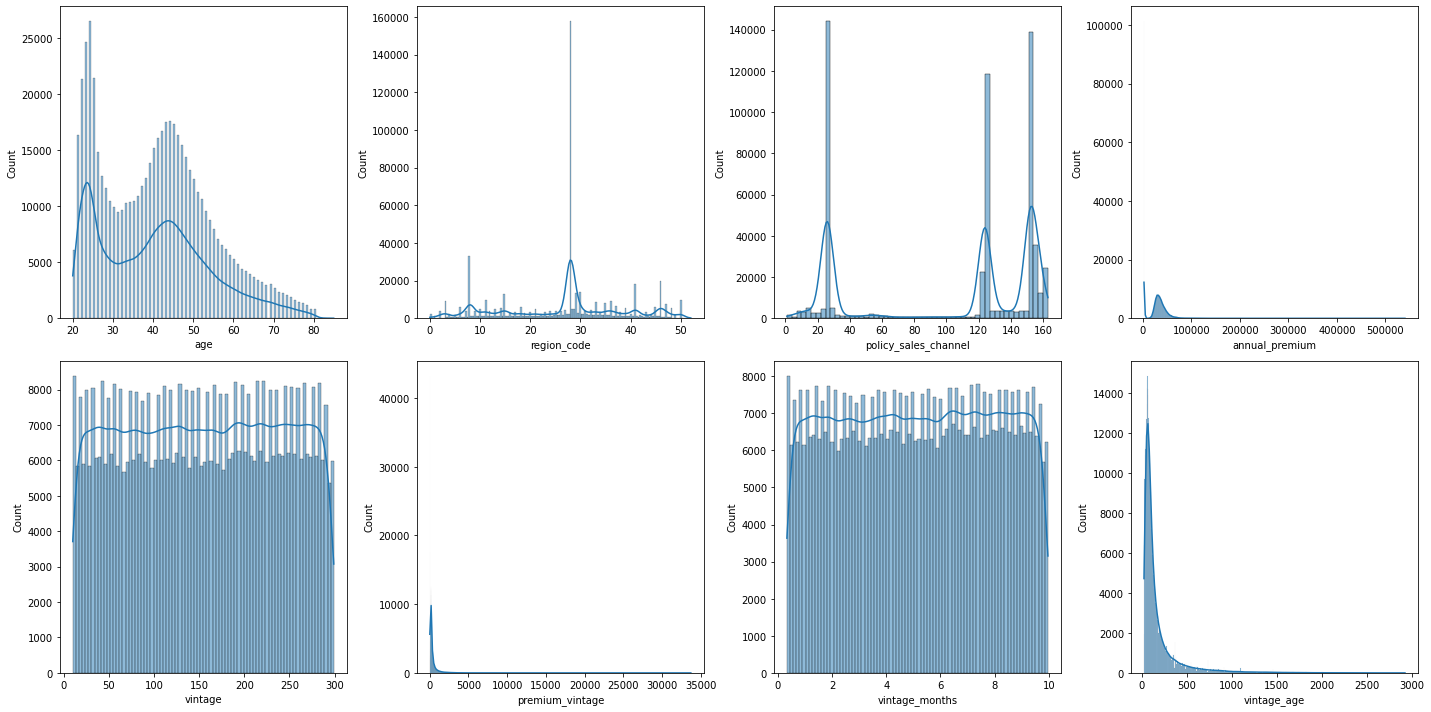

In [47]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(2, 4, 1);
sns.histplot(num_attributes['age'], kde=True)

plt.subplot(2, 4, 2);
sns.histplot(num_attributes['region_code'], kde=True)

plt.subplot(2, 4, 3);
sns.histplot(num_attributes['policy_sales_channel'], kde=True)

plt.subplot(2, 4, 4);
sns.histplot(num_attributes['annual_premium'], kde=True)

plt.subplot(2, 4, 5);
sns.histplot(num_attributes['vintage'], kde=True)

plt.subplot(2, 4, 6);
sns.histplot(num_attributes['premium_vintage'], kde=True)

plt.subplot(2, 4, 7);
sns.histplot(num_attributes['vintage_months'], kde=True)

plt.subplot(2, 4, 8);
sns.histplot(num_attributes['vintage_age'], kde=True)
plt.tight_layout();

### 3.1.3. Categorical Variables Analysis

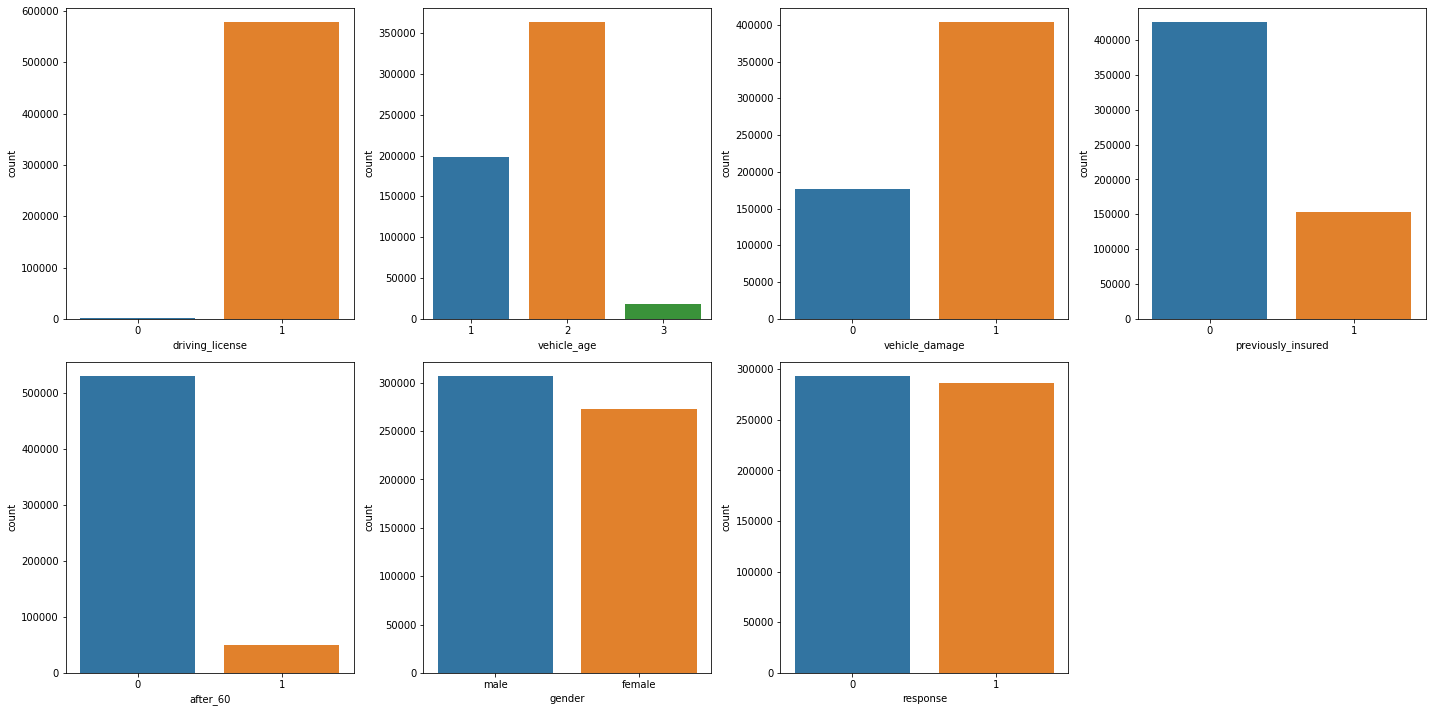

In [46]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(2, 4, 1);
sns.countplot(cat_attributes['driving_license'])

plt.subplot(2, 4, 2);
sns.countplot(cat_attributes['vehicle_age'])

plt.subplot(2, 4, 3);
sns.countplot(cat_attributes['vehicle_damage'])

plt.subplot(2, 4, 4);
sns.countplot(cat_attributes['previously_insured'])

plt.subplot(2, 4, 5);
sns.countplot(cat_attributes['after_60'])

plt.subplot(2, 4, 6);
sns.countplot(cat_attributes['gender'])

plt.subplot(2, 4, 7);
sns.countplot(cat_attributes['response'])
plt.tight_layout();

## 3.2. Bivariate Analysis

### H1: Middle aged customers should be more likely to purchase the vehicle insurance.
**<font color='green'>TRUE</font>**: customers between 35 and 55 years old are more interested in purchasing the insurance.<br>
**Relevance**: <font color='green'>High</font>: both means are statistically different and also the distribution, which reflects a difference in the behaviour of the feature<br>

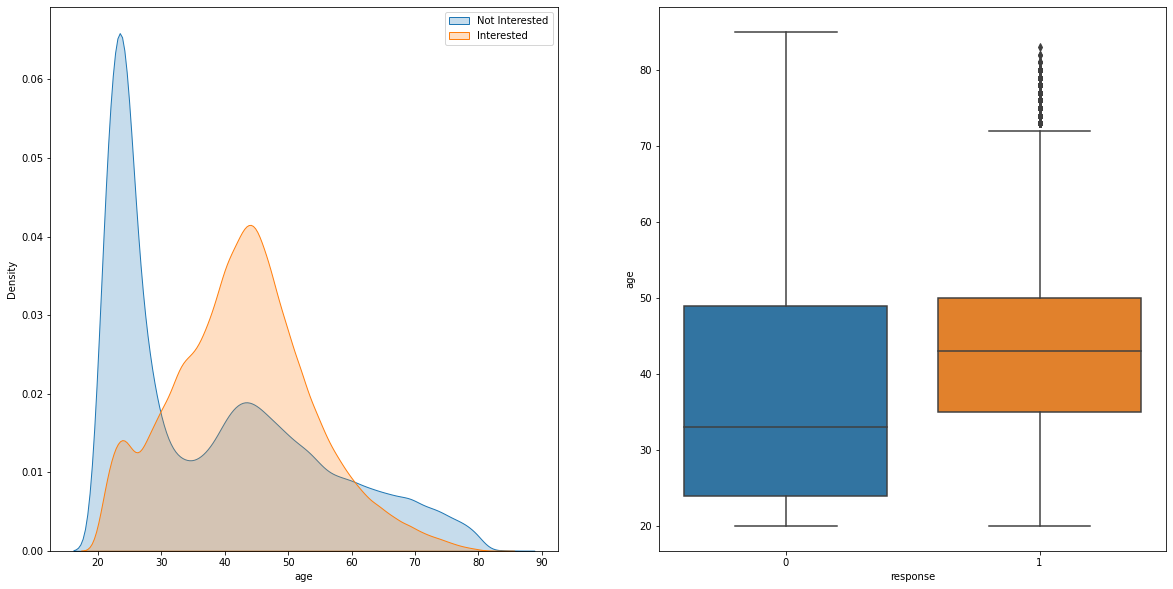

In [7]:
plt.figure( figsize = ( 20, 10 ) )

plt.subplot(1,2,1)
sns.kdeplot(df3[df3['response'] == 0]['age'], fill = True, label = 'Not Interested')
sns.kdeplot(df3[df3['response'] == 1]['age'], fill = True, label = 'Interested')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot( y = 'age', x = 'response', data = df3);

Let's perform a statistical test to check if the average `age` between interested and not interested customers are equal. **Rejecting the null hypothesis (the two means are statistically equal), we could consider `age` relevant to determine the interest in purchasing the insurance**.

$$ H_0: \mu_a = \mu_b $$
$$ H_1: \mu_a ≠ \mu_b $$

In [83]:
# separating customers interested and not interested in purchasing the insurance
cus_not_interested = df3[df3['response'] == 0]['age'].to_list()
cus_interested = df3[df3['response'] == 1]['age'].to_list()

# calculating confidence interval for sample of customers age interested in purchasing the insurance
confidence_level = 0.95
degrees_freedom = len(cus_interested) - 1
sample_mean = np.mean(cus_interested)
sample_standard_error = ss.sem(cus_interested)
CI = ss.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = ss.ttest_ind(cus_interested,cus_not_interested, equal_var = False)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean Age for Customers not Interested = " + str(np.mean(cus_not_interested)))

t-test = 136.40029412960362
p-value = 0.0
Confidence Interval (95%) = (42.911060151621385, 42.991246127242036)
Mean Age for Customers not Interested = 38.073989240411265


Since the p-value is lower than the alpha value, 0.05, and the mean age of patients not interested in purchasing the vehicle insurance is not between the confidence interval, we reject the null hypothesis that the two means are equal.

<AxesSubplot:xlabel='age', ylabel='count'>

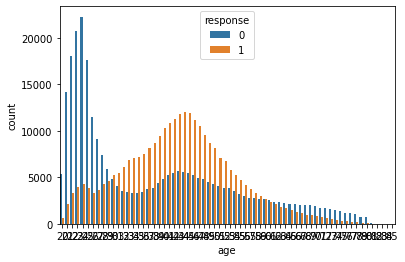

In [5]:
sns.countplot(x = 'age', hue = 'response', data = df3)

### H2: Customers who have driving license should be more likely to purchase the vehicle insurance.
**<font color='green'>TRUE</font>**: the proportion of customers interested in purchasing the insurance is slightly greater among those who have driving license. <br>
**Relevance**: <font color='red'>Low</font>, since the difference is not too large and this feature is very imbalanced (99.7% of the customers have driving license)

In [57]:
# checking the balance of the feature
df3['driving_license'].value_counts(normalize = True)

1    0.997939
0    0.002061
Name: driving_license, dtype: float64

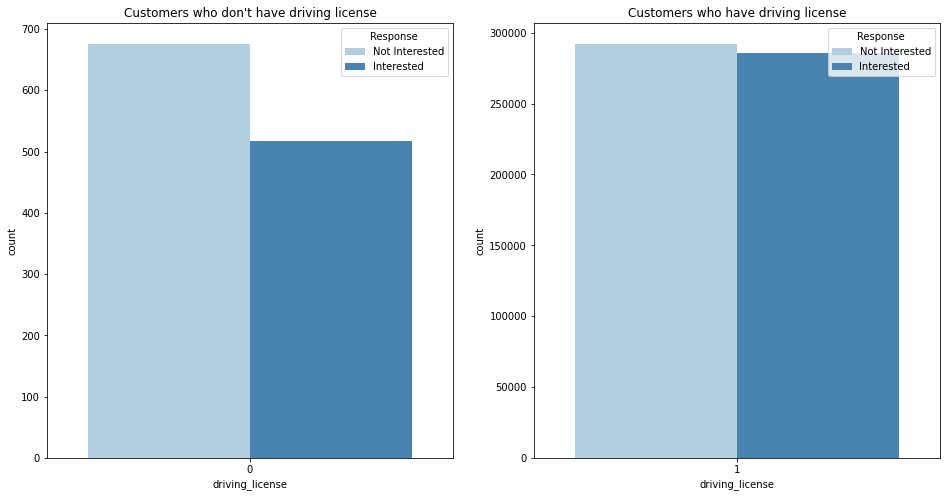

In [32]:
plt.figure(figsize = [16,8])
plt.subplot(1,2,1)
sns.countplot(x = 'driving_license', hue = 'response', data = df3[df3['driving_license'] == 0], palette = 'Blues')
plt.title('Customers who don\'t have driving license')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'driving_license', hue = 'response', data = df3[df3['driving_license'] == 1], palette = 'Blues')
plt.title('Customers who have driving license')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

Let's take a better look at the proportion:

In [55]:
print('Percentage of customers without driving license who are interested in purchasing the insurance: {:.2f}%'.format(df3[df3['driving_license'] == 0]['response'].sum() / len(df3[df3['driving_license'] == 0])*100))
print('Percentage of customers with driving license who are interested in purchasing the insurance: {:.2f}%'.format(df3[df3['driving_license'] == 1]['response'].sum() / len(df3[df3['driving_license'] == 1])*100))

Percentage of customers without driving license who are interested in purchasing the insurance: 43.38%
Percentage of customers with driving license who are interested in purchasing the insurance: 49.44%


### H3: Customers who have their vehicles damaged in the past should be more likely to purchase the vehicle insurance.
**<font color='green'>TRUE</font>**: the proportion of customers interested in purchasing the insurance is much higher among those who have had their vehicles damaged. <br>
**Relevance**: <font color='orange'>Medium</font>, allthough the difference is high, this feature is imbalanced (about 70% of the customers have had their cars damaged)

In [59]:
# checking the balance of the feature
df3['vehicle_damage'].value_counts(normalize = True)

1    0.696053
0    0.303947
Name: vehicle_damage, dtype: float64

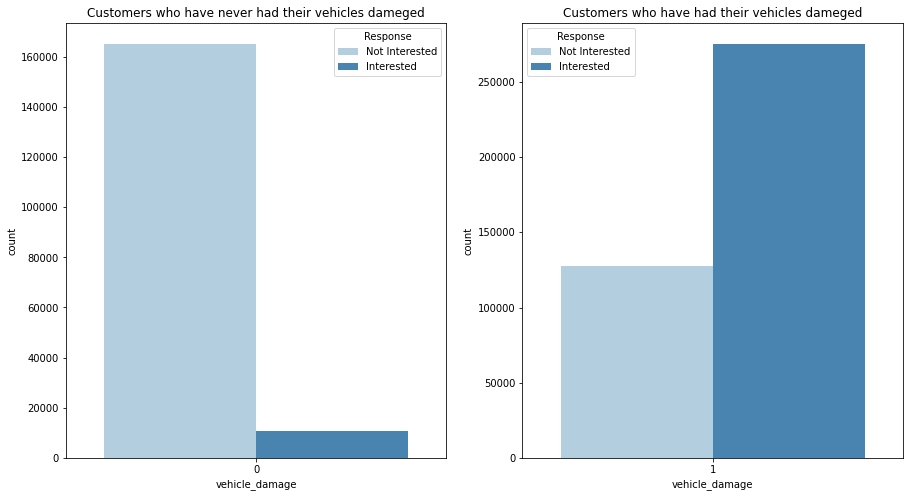

In [31]:
plt.figure(figsize = [15,8])
plt.subplot(1,2,1)
sns.countplot(x = 'vehicle_damage', hue = 'response', data = df3[df3['vehicle_damage'] == 0], palette = 'Blues')
plt.title('Customers who have never had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'vehicle_damage', hue = 'response', data = df3[df3['vehicle_damage'] == 1], palette = 'Blues')
plt.title('Customers who have had their vehicles dameged')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

Let's take a better look at the proportion:

In [61]:
print('Percentage of customers who have not had their vehicles damaged and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_damage'] == 0]['response'].sum() / len(df3[df3['vehicle_damage'] == 0])*100))
print('Percentage of customers who have had their vehicles damaged and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_damage'] == 1]['response'].sum() / len(df3[df3['vehicle_damage'] == 1])*100))

Percentage of customers who have not had their vehicles damaged and are interested in the insurance: 6.17%
Percentage of customers who have had their vehicles damaged and are interested in the insurance: 68.31%


### H4: Women are more likely to purchase a vehicle insurance than men.
**<font color='red'>FALSE</font>**: the proportion of customers interested in purchasing the insurance is higher among males. Besides that, among the customers interested in purchasing the insurance, there are more men. <br>
**Relevance**: <font color='orange'>Medium</font>, since the difference in proportion is not too high.

In [70]:
# checking the balance of the feature
df3['gender'].value_counts(normalize = True)

male      0.529183
female    0.470817
Name: gender, dtype: float64

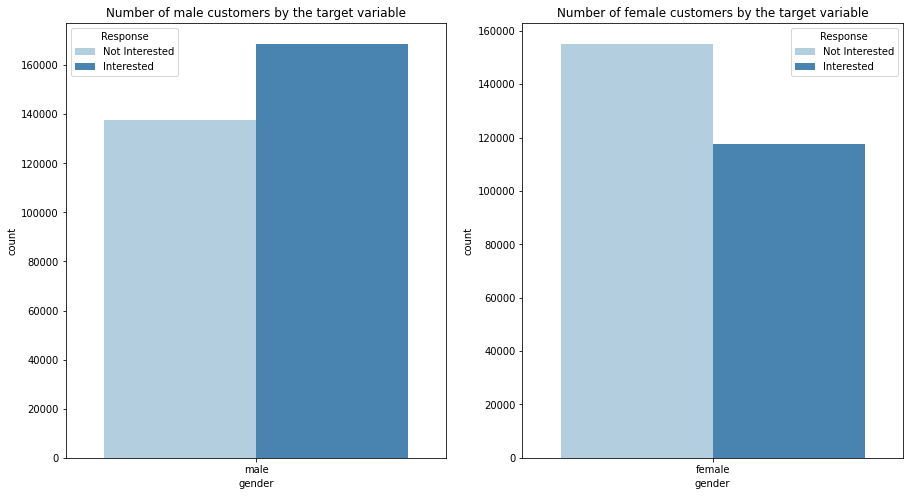

In [36]:
plt.figure(figsize = [15,8])

plt.subplot(1,2,1)
sns.countplot(x = 'gender', hue = 'response', data = df3[df3['gender'] == 'male'], palette = 'Blues')
plt.title('Number of male customers by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'gender', hue = 'response', data = df3[df3['gender'] == 'female'], palette = 'Blues')
plt.title('Number of female customers by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

In [63]:
print('Percentage of men interested in the insurance: {:.2f}%'.format(df3[df3['gender'] == 'male']['response'].sum() / len(df3[df3['gender'] == 'male'])*100))
print('Percentage of men interested in the insurance: {:.2f}%'.format(df3[df3['gender'] == 'female']['response'].sum() / len(df3[df3['gender'] == 'female'])*100))

Percentage of men interested in the insurance: 55.05%
Percentage of men interested in the insurance: 43.10%


### <s>H5: The customer's interest for vehicle insurance should differ between region codes.</s>
This Hypothesis will be validated in the next CRISP-DM cycle

### H6: The longer as a customer, the more likely to purchase the vehicle insurance he/she should be.
**<font color='red'>FALSE</font>**: there's no evidence of such a difference. <br>
**Relevance**: <font color='red'>Low</font>, the vintage mean is not too different between the two groups (interested and not interested in the insurance).

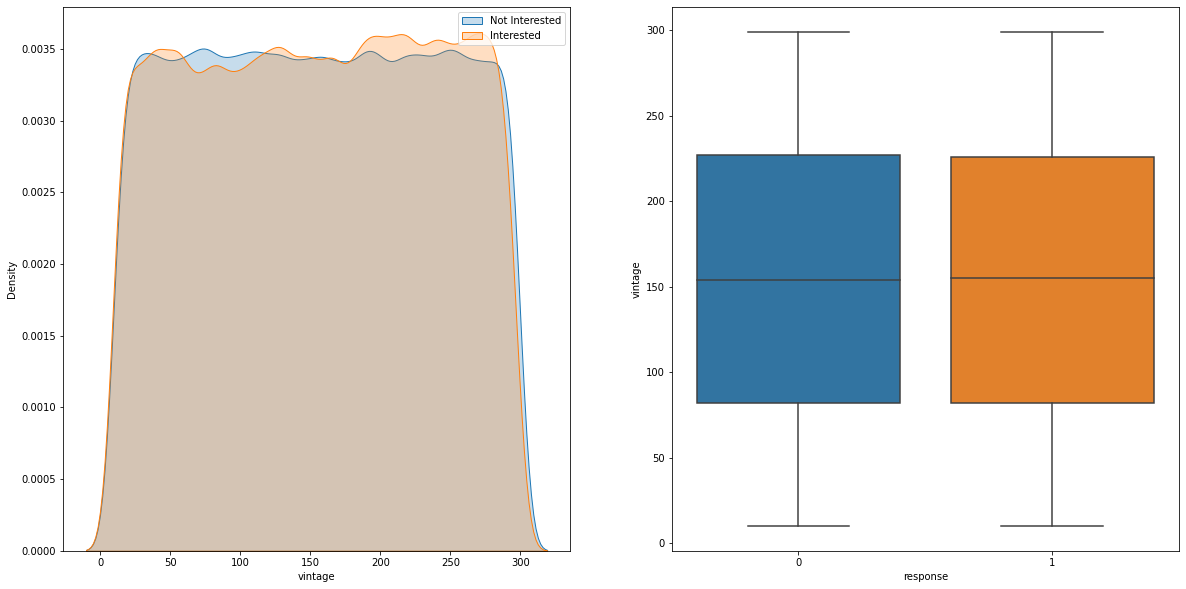

In [81]:
plt.figure( figsize = ( 20, 10 ) )

plt.subplot(1,2,1)
sns.kdeplot(df3[df3['response'] == 0]['vintage'], fill = True, label = 'Not Interested')
sns.kdeplot(df3[df3['response'] == 1]['vintage'], fill = True, label = 'Interested')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot( y = 'vintage', x = 'response', data = df3);

In [84]:
# separating customers interested and not interested in purchasing the insurance
cus_not_interested = df3[df3['response'] == 0]['vintage'].to_list()
cus_interested = df3[df3['response'] == 1]['vintage'].to_list()

# calculating confidence interval for sample of patients' vintage interested in purchasing the insurance
confidence_level = 0.95
degrees_freedom = len(cus_interested) - 1
sample_mean = np.mean(cus_interested)
sample_standard_error = ss.sem(cus_interested)
CI = ss.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = ss.ttest_ind(cus_interested,cus_not_interested, equal_var = False)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean vintage for Customers not Interested = " + str(np.mean(cus_not_interested)))

t-test = -2.109492800533424
p-value = 0.03490249478936552
Confidence Interval (95%) = (153.7687023033922, 154.3771500975552)
Mean vintage for Customers not Interested = 154.53496866338054


### H7: The more the customer spent on our products, the more he/she should be to purchase the vehicle insurance.
**<font color='green'>TRUE</font>**: even though it is not too large, the average annual_premium for customers who are interested in purchasing the insurance is higher. <br>
**Relevance**: <font color='orange'>Medium</font>, the mean is not too different.

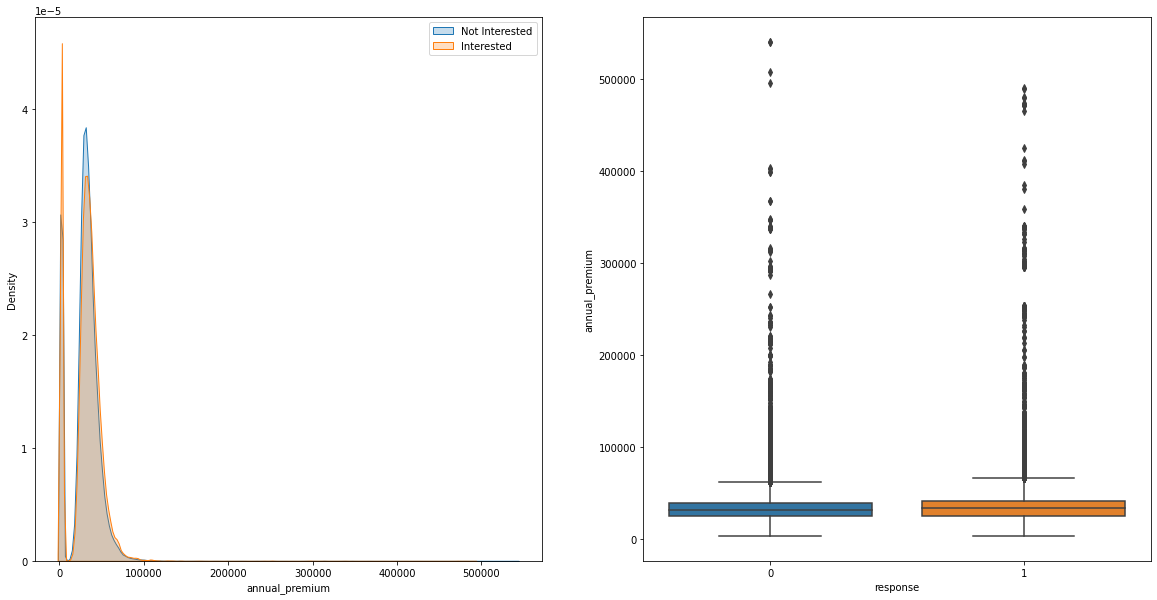

In [94]:
plt.figure( figsize = ( 20, 10 ) )

plt.subplot(1,2,1)
sns.kdeplot(df3[df3['response'] == 0]['annual_premium'], fill = True, label = 'Not Interested')
sns.kdeplot(df3[df3['response'] == 1]['annual_premium'], fill = True, label = 'Interested')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot( y = 'annual_premium', x = 'response', data = df3);

In [97]:
print('annual_premium mean of customers not interested in purchasing: {}'.format(df3[df3['response'] == 0 ]['annual_premium'].mean()))
print('annual_premium mean of customers interested in purchasing: {}'.format(df3[df3['response'] == 1 ]['annual_premium'].mean()))

annual_premium mean of customers not interested in purchasing: 30377.285822057158
annual_premium mean of customers interested in purchasing: 31563.268406751107


In [96]:
# separating customers interested and not interested in purchasing the insurance
cus_not_interested = df3[df3['response'] == 0]['annual_premium'].to_list()
cus_interested = df3[df3['response'] == 1]['annual_premium'].to_list()

# calculating confidence interval for sample of patients' annual_premium interested in purchasing the insurance
confidence_level = 0.95
degrees_freedom = len(cus_interested) - 1
sample_mean = np.mean(cus_interested)
sample_standard_error = ss.sem(cus_interested)
CI = ss.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = ss.ttest_ind(cus_interested,cus_not_interested, equal_var = False)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean annual_premium for Customers not Interested = " + str(np.mean(cus_not_interested)))

t-test = 25.70704779234447
p-value = 1.1802216160203434e-145
Confidence Interval (95%) = (31496.3544199508, 31630.182393551415)
Mean annual_premium for Customers not Interested = 30377.285822057158


### H8: Customers who spent more in less time as a customer are more likely to purchase the vehicle insurance. 
**<font color='green'>TRUE</font>**: even though it is not too large, the premium_vintage average for customers who are interested in purchasing the insurance is higher. <br>
**Relevance**: <font color='orange'>Medium</font>, the mean is not too different.

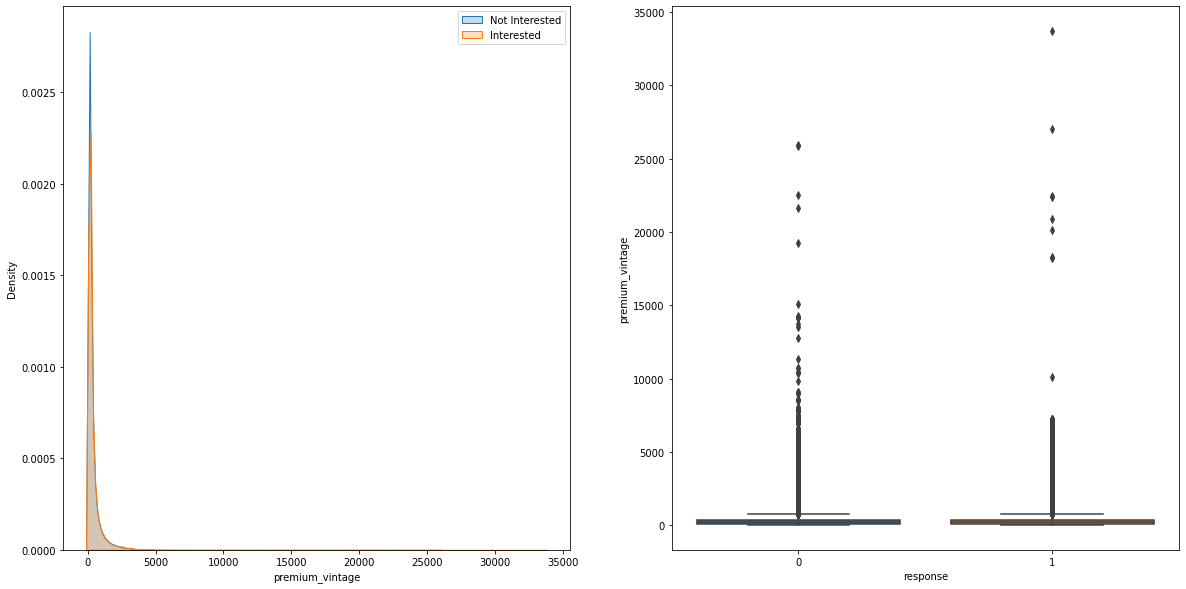

In [89]:
plt.figure( figsize = ( 20, 10 ) )

plt.subplot(1,2,1)
sns.kdeplot(df3[df3['response'] == 0]['premium_vintage'], fill = True, label = 'Not Interested')
sns.kdeplot(df3[df3['response'] == 1]['premium_vintage'], fill = True, label = 'Interested')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot( y = 'premium_vintage', x = 'response', data = df3);

In [92]:
print('premium_vintage mean of customers not interested in purchasing: {}'.format(df3[df3['response'] == 0 ]['premium_vintage'].mean()))
print('premium_vintage mean of customers interested in purchasing: {}'.format(df3[df3['response'] == 1 ]['premium_vintage'].mean()))

premium_vintage mean of customers not interested in purchasing: 360.8248474777595
premium_vintage mean of customers interested in purchasing: 372.5099683930762


In [93]:
# separating customers interested and not interested in purchasing the insurance
cus_not_interested = df3[df3['response'] == 0]['premium_vintage'].to_list()
cus_interested = df3[df3['response'] == 1]['premium_vintage'].to_list()

# calculating confidence interval for sample of patients' premium_vintage interested in purchasing the insurance
confidence_level = 0.95
degrees_freedom = len(cus_interested) - 1
sample_mean = np.mean(cus_interested)
sample_standard_error = ss.sem(cus_interested)
CI = ss.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = ss.ttest_ind(cus_interested,cus_not_interested, equal_var = False)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean premium_vintage for Customers not Interested = " + str(np.mean(cus_not_interested)))

t-test = 8.025851872262429
p-value = 1.0101077475904093e-15
Confidence Interval (95%) = (370.4442325682529, 374.57570421789944)
Mean premium_vintage for Customers not Interested = 360.8248474777595


### H9: The younger the customer's vehicle, the more likely he/she should be to purchase the vehicle insurance.
**<font color='red'>FALSE</font>**: customers who have a car aged between 1 and 2 years are more interested in purchasing the insurance. The proportion is lower for customers with cars over 2 years old. <br>
**Relevance**: <font color='orange'>Medium</font>, since the feature is very imbalanced.

In [111]:
print('Percentage of customers who have a car aged less than 1 year and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_age'] == 1]['response'].sum() / len(df3[df3['vehicle_age'] == 1])*100))
print('Percentage of customers who have a car aged between 1 and 2 years and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_age'] == 2]['response'].sum() / len(df3[df3['vehicle_age'] == 2])*100))
print('Percentage of customers who have a car over 2 years old and are interested in the insurance: {:.2f}%'.format(df3[df3['vehicle_age'] == 3]['response'].sum() / len(df3[df3['vehicle_age'] == 3])*100))

Percentage of customers who have a car aged less than 1 year and are interested in the insurance: 29.52%
Percentage of customers who have a car aged between 1 and 2 years and are interested in the insurance: 60.50%
Percentage of customers who have a car over 2 years old and are interested in the insurance: 45.14%


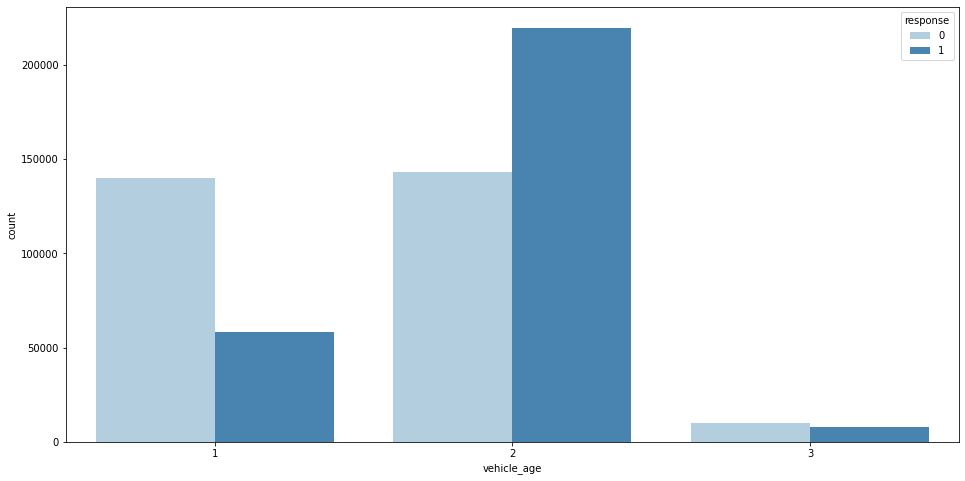

In [39]:
plt.figure(figsize=[16,8])
sns.countplot(x = 'vehicle_age', hue = 'response', data=df3, palette = 'Blues');

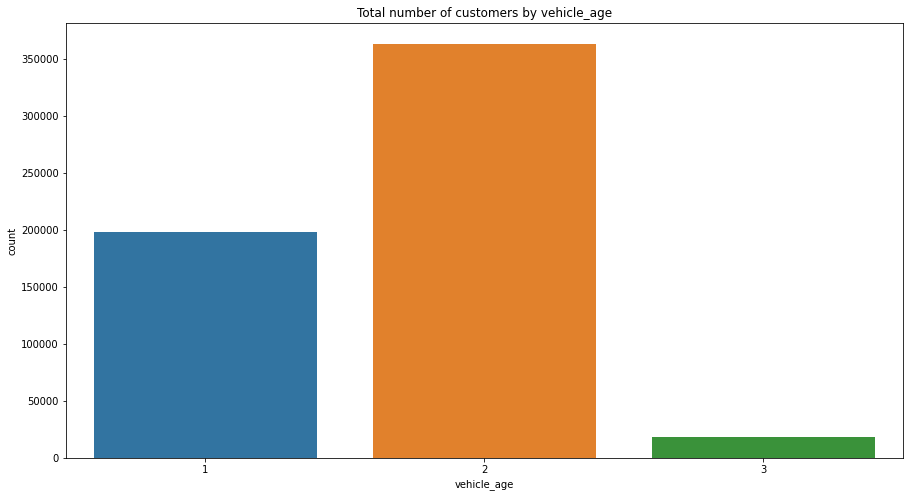

In [134]:
plt.figure(figsize = [15,8])

plt.subplot(1,2,1)
sns.countplot(x = 'vehicle_age', hue = 'response', data = df3[df3['vehicle_age'] == 'male'], palette = 'Blues')
plt.title('Number of male customers by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])

plt.subplot(1,2,2)
sns.countplot(x = 'vehicle_age', hue = 'response', data = df3[df3['gender'] == 'female'], palette = 'Blues')
plt.title('Number of female customers by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested']);

### H10: Customers who don't have a vehicle insurance should be more likely to purchase one.
**<font color='green'>TRUE</font>**: customers who do not have or have never had a vehicle insurance are more interested in purchasing the insurance.<br>
**Relevance**: <font color='orange'>Medium</font>, since the feature is very imbalanced.

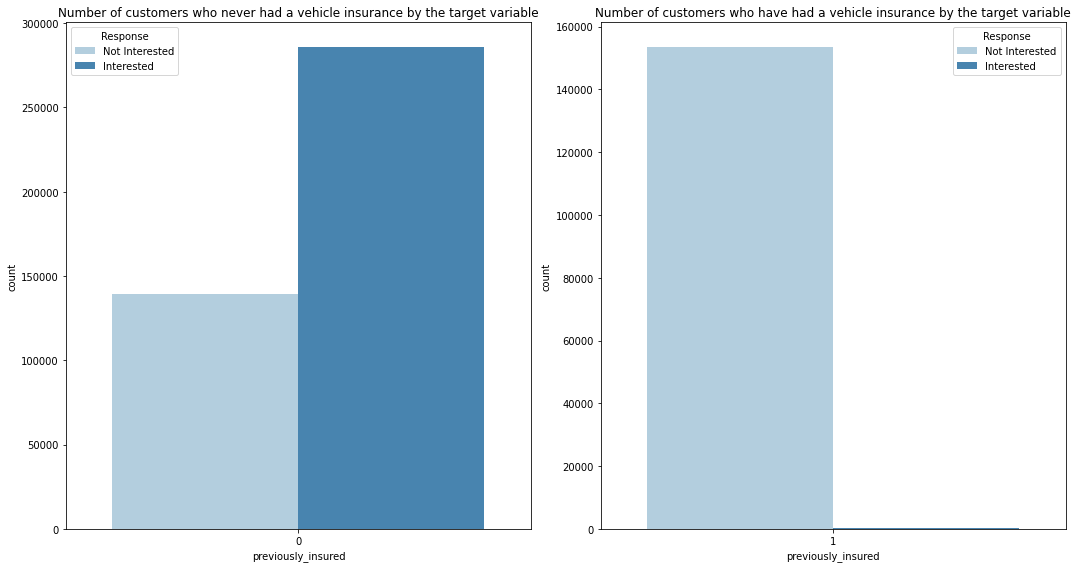

In [43]:
plt.figure(figsize = [15,8])

plt.subplot(1,2,1)
sns.countplot(x = 'previously_insured', hue = 'response', data = df3[df3['previously_insured'] == 0], palette = 'Blues')
plt.title('Number of customers who never had a vehicle insurance by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])


plt.subplot(1,2,2)
sns.countplot(x = 'previously_insured', hue = 'response', data = df3[df3['previously_insured'] == 1], palette = 'Blues')
plt.title('Number of customers who have had a vehicle insurance by the target variable')
plt.legend(title='Response',labels = ['Not Interested', 'Interested'])
plt.tight_layout();

Since we can't clearly see the differences in the second chart, let's take a look at the proportions.

In [121]:
print('Percentage of customers who do not have or have never had a vehicel insurance and are interested in the insurance: {:.2f}%'.format(df3[df3['previously_insured'] == 0]['response'].sum() / len(df3[df3['previously_insured'] == 0])*100))
print('Percentage of customers who have/have had a vehicel insurance and are interested in the insurance: {:.2f}%'.format(df3[df3['previously_insured'] == 1]['response'].sum() / len(df3[df3['previously_insured'] == 1])*100))

Percentage of customers who do not have or have never had a vehicel insurance and are interested in the insurance: 67.26%
Percentage of customers who have/have had a vehicel insurance and are interested in the insurance: 0.09%


### 3.1.2. Hypothesis Validation Summary

| Hypothesis | Feature | Validation | Relevance |
| --- | --- | --- | --- |
| H1 | `age` | <font color='green'>True</font> | <font color='green'>High</font> |
| H2 | `driving_license` | <font color='green'>True</font> | <font color='red'>Low</font> |
| H3 | `vehicle_damaged` | <font color='green'>True</font> | <font color='red'>Low</font> |
| H4 | `gender` | <font color='red'>False</font> | <font color='orange'>Medium</font> |
| H5 | `region_code` | --- |  |
| H6 | `vintage` | <font color='red'>False</font> | <font color='red'>Low</font> |
| H7 | `annual_premium` | <font color='green'>True</font> | <font color='orange'>Medium</font> |
| H8 | `premium_vintage` | <font color='green'>True</font> | <font color='orange'>Medium</font> |
| H9 | `vehicle_age` | <font color='red'>False</font> | <font color='orange'>Medium</font> |
| H10 | `previously_insured` | <font color='green'>True</font> | <font color='orange'>Medium</font> |

## 3.2. Multiivariate Analysis

### 3.2.1. Numerical Features + Target

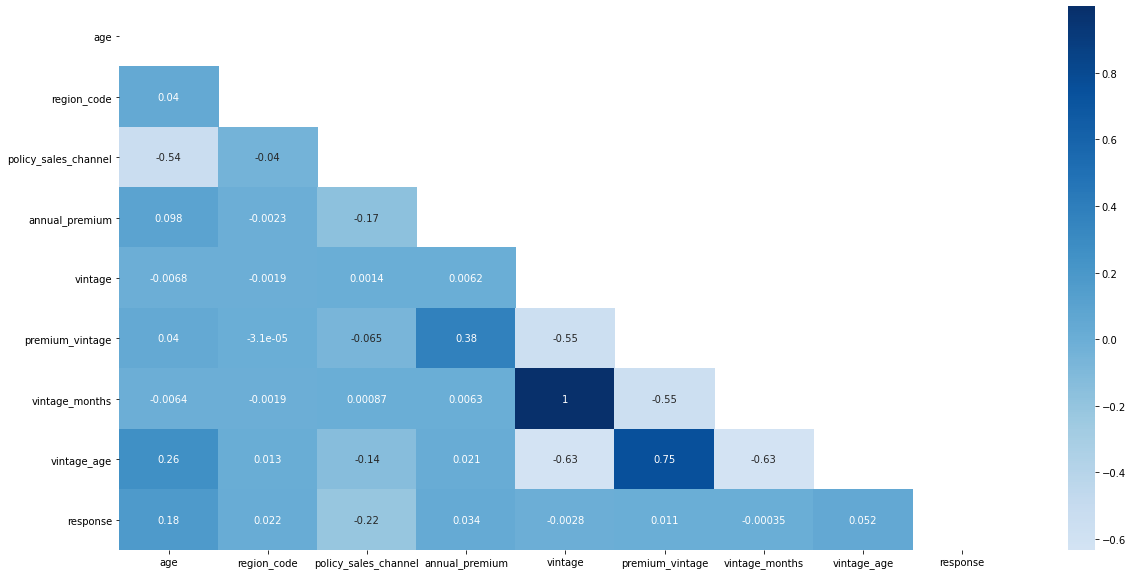

In [164]:
# calculating pearson correlations
df_corr = num_attributes.corr(method = 'pearson')

# calculating point-biserial correlations
interest = []
for i, j in enumerate(num_attributes.columns):
    result = ss.pointbiserialr(num_attributes[f'{j}'], cat_attributes['response'])[0]
    interest.append(result)
    if i == 7:
        df_corr.loc['response'] = interest
        interest.append(1)
df_corr['response'] = interest

## plotting
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (20,10))
sns.heatmap(df_corr,cmap='Blues',mask = mask,annot=True, 
            center = 0,);

### 3.2.2. Categorical Features + Target

<AxesSubplot:>

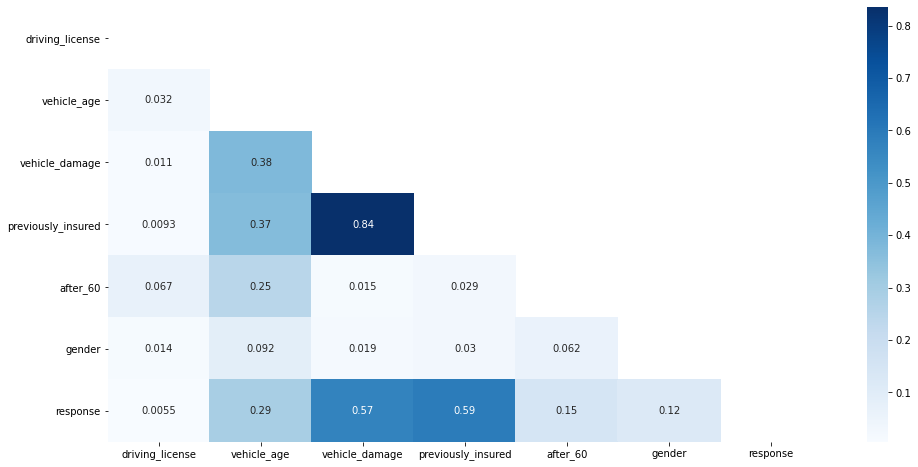

In [158]:
# changing attriutes type so the Cramér-V function doesn't return an error
cat_attributes['driving_license'] = cat_attributes['driving_license'].map({1: 'yes', 0:'no' })
cat_attributes['previously_insured'] = cat_attributes['previously_insured'].map({1: 'yes', 0:'no' })
cat_attributes['response'] = cat_attributes['response'].map({1: 'yes', 0:'no' })
cat_attributes['vehicle_age'] = cat_attributes['vehicle_age'].map({1: '< 1 Year', 2:'1-2 Year', 3: '> 2 Years ' })
cat_attributes['after_60'] = cat_attributes['after_60'].map({1: 'yes', 0:'no' })

cat_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # calculating the correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # appending to the list
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)
mask = np.zeros_like( cat_corr, dtype=np.bool )
mask[np.triu_indices_from( mask )] = True

plt.subplots(figsize = (16,8))
sns.heatmap(cat_corr, cmap='Blues', mask = mask, annot=True);

## 3.3. EDA SUMMARY

| Hypothesis | Feature | Validation | Relevance |
| --- | --- | --- | --- |
| H1 | `age` | <font color='green'>True</font> | <font color='green'>High</font> |
| H2 | `driving_license` | <font color='green'>True</font> | <font color='red'>Low</font> |
| H3 | `vehicle_damaged` | <font color='green'>True</font> | <font color='red'>Low</font> |
| H4 | `gender` | <font color='red'>False</font> | <font color='orange'>Medium</font> |
| H5 | `region_code` | --- | --- |
| H6 | `vintage` | <font color='red'>False</font> | <font color='red'>Low</font> |
| H7 | `annual_premium` | <font color='green'>True</font> | <font color='orange'>Medium</font> |
| H8 | `premium_vintage` | <font color='green'>True</font> | <font color='orange'>Medium</font> |
| H9 | `vehicle_age` | <font color='red'>False</font> | <font color='orange'>Medium</font> |
| H10 | `previously_insured` | <font color='green'>True</font> | <font color='orange'>Medium</font> |
| -- | `policy_sales_channel` | -- | <font color='red'>Low</font> |
| -- | `after_60` | -- | <font color='red'>Low</font> |
| -- | `vintage_months` | -- | <font color='red'>Low</font> |
| -- | `vintage_age` | -- | <font color='red'>Low</font> |

# 4.0. STEP 4: DATA PREPROCESSING

## 4.1. Rescaling

In [5]:
rs = RobustScaler()

In [6]:
df4 = df3.copy()

In [7]:
df4['age'] = rs.fit_transform( df4[['age']].values )
df4['region_code'] = rs.fit_transform( df4[['region_code']].values )
df4['policy_sales_channel'] = rs.fit_transform( df4[['policy_sales_channel']].values )
df4['annual_premium'] = rs.fit_transform( df4[['annual_premium']].values )
df4['vintage'] = rs.fit_transform( df4[['vintage']].values )
df4['premium_vintage'] = rs.fit_transform( df4[['premium_vintage']].values )
df4['vintage_months'] = rs.fit_transform( df4[['vintage_months']].values )
df4['vintage_age'] = rs.fit_transform( df4[['vintage_age']].values )

## 4.2. Encoding

In [8]:
df4[['male', 'female']] = pd.get_dummies(df4['gender'])

# 5.0. STEP 5: FEATURE SELECTION

# 6.0. STEP 6: MACHINE LEARNING MODELING